In [47]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Implementation of the Position Class Representing a Game State

The `Position` class object is created using three main values:
- Number of tokens on the table
- Number of player's tokens
- Number of opponent's tokens

Additionally, the constructor takes a `reference to the parent` of the current position (the root position in the game has None as its parent). The `n and k values are const` and won't change during the game.

Upon object creation, the method `self.set_legal_moves()` is called. Based on the remaining number of tokens on the table, this method populates the `self.legal_moves` list with all possible moves that can be made in the current position. This information is crucial for creating children positions in the game tree.

The class also has a method `self.is_terminal_position()` that returns True if the current position is terminal. If there is only one token on the table, it means the player must take it and loses the game. Therefore, the method returns True when `self.table_tokens == 1`.

Method `self.next_best_move()` returns the best move to make. This method is used after analyzing the game tree when transitioning to the next state. When multiple children have the same cost, one is randomly chosen.

The `generate_child()` method creates a child position based on the move passed as an argument. The child position is created by subtracting the number of tokens from the table and the addig this number to the player's tokens. The opponent tokens are changed when the is_max_round is eqaul to False.

In [55]:
from __future__ import annotations

class Position:
    def __init__(self, table : int, player : int, opponent : int, parent, n: int, k : int=3) -> None:
        self.table_tokens = table
        self.max_tokens = player
        self.min_tokens = opponent
        self.k = k
        self.n = n
        self.legal_moves = self.set_legal_moves()
        self.cost = None
        self.parent = parent
        self.children = []

    def get_table_token(self) -> int:
        return self.table_tokens

    def get_legal_moves(self) -> list:
        return self.legal_moves

    def set_legal_moves(self) -> list:
        if self.table_tokens > self.k:
            moves = [i for i in range(1, self.k+1)]
        else:
            moves = [i for i in range(1, self.table_tokens)]
        return moves

    def is_terminal_position(self) -> bool:
        return True if self.table_tokens == 1 else False

    def set_cost(self, cost : float) -> None:
        self.cost = cost

    def clear(self) -> None:
        self.children = []

    def next_best_move(self, maximizing : bool) -> Position:
        sorted_children = sorted(self.children, key=lambda x: x.cost, reverse=maximizing)
        best_child = random.choice([child for child in sorted_children if child.cost == sorted_children[0].cost])
        return best_child

    def generate_child(self, gained_tokens: int, is_max_round: bool) -> Position:
        if is_max_round:
            child = Position(self.table_tokens - gained_tokens, self.max_tokens + gained_tokens, self.min_tokens, self, self.n, self.k)
        else:
            child = Position(self.table_tokens - gained_tokens, self.max_tokens, self.min_tokens + gained_tokens, self, self.n, self.k)
        self.children.append(child)
        return child

***Random Heuristic Function***

The `random_heuristic()` function returns a random value between -1 and 1. It represents a "dumb" algorithm that does not analyze the game tree but instead randomly selects moves. This function serves as a helper to compare with the minimax algorithm.

In [49]:
def random_heuristic(position: Position, is_max_round: bool) -> float:
    return random.uniform(-1, 1)

***Naive Heuristic Function***

The `naive_heuristic()` function returns a value of -1 when the game ended during the Max player's turn (Max lost), returns 1 when the game ended during the Min player's turn (Max won), and returns 0 when the game has not yet ended. This heuristic is not very sophisticated but aims to prevent "dumb" moves.

In [50]:
def naive_heuristic(position: Position, is_max_round: bool) -> int:
    if position.get_table_token() == 1 and is_max_round:
        return -1
    elif position.get_table_token() == 1 and not is_max_round:
        return 1
    else:
        return 0

***Custom Heuristic Function***

The `my_heuristic` function takes a `Position` object and boolean indicating whether it is the Max player's turn (`is_max_round`). It calculates a heuristic value based on the following conditions:

- If there is 1 or 5 token on the table and it's Max player's turn, the function returns -1, indicating a potential loss for Max.
- If there is 1 or 5 token on the table and it's Min player's turn, the function returns 1, indicating a potential win for Max.
- If there are 2, 3, or 4 tokens on the table and it's Max player's turn, the function returns 1 (potential win position for Max).
- If there are 2, 3, or 4 tokens on the table and it's Min player's turn, the function returns -1 (potential win for Min).
- In all other cases, the function returns a value calculated as `-position.table_tokens / n` if it's Max player's turn and `position.table_tokens / n` if it's Min player's turn. This is a proportional heuristic based on the remaining tokens on the table.

In [51]:
def my_heuristic(position: Position, is_max_round: bool) -> float:
    if position.get_table_token() in (1, 5) and is_max_round:
        return -1
    elif position.get_table_token() in (1, 5) and not is_max_round:
        return 1
    elif position.get_table_token() in (2, 3, 4) and is_max_round:
        return 1
    elif position.get_table_token() in (2, 3, 4) and not is_max_round:
        return -1
    else:
        return -position.get_table_token() / position.n if is_max_round else position.get_table_token() / position.n

***Broken Heuristic Function***

This heuristic is different from the others. I noticed that `a player who reaches a number of tokens equal to (K+1)X+1`, where K is the maximum number of tokens to be taken in a turn, `he is doomed to lose the game` if the second player is aware of this tactic. Interestingly, the heuristic does not depend on the depth of search, solely on N, the initial number of tokens, and on which player starts. If N is a number that can be expressed as (K+1)X+1, then the player starting the game will lose 100%. For this specific game, it turns out that `the minimax algorithm is not needed at all`.

In [52]:
def broken_heuristic(position: Position, is_max_round: bool) -> int:
    if position.get_table_token() == 1:
        return -2 if is_max_round else 2
    result = -1 if position.get_table_token() % (position.k+1) == 1 else 1
    return result if is_max_round else -result

***Minimax Algorithm***

The `minimax` function implements the Minimax algorithm for game tree traversal. It takes a `Position` object, a depth limit, alpha and beta values for pruning, a boolean flag indicating whether it's the Max player's turn (`is_max_round`) and heuristic function.
***Parameters***

- `position`: Current state of the game represented by a `Position` object.
- `depth`: The maximum depth to explore in the game tree.
- `alpha`: The alpha value for alpha-beta pruning, initialized to negative infinity.
- `beta`: The beta value for alpha-beta pruning, initialized to positive infinity.
- `is_max_round`: A boolean flag indicating whether it's the Max player's turn.
- `heuristic`: A callable heuristic function used to evaluate the cost of Position objects. Heuristic must take two positional arguments: a `Position` object and a boolean flag indicating whether it's the Max player's turn.

***Description***

The function recursively explores the game tree using the Minimax algorithm. It evaluates the current state using the provided heuristic function when the maximum depth is reached or when the state is terminal. The function updates the cost of the current position accordingly.

If it's the Max player's turn, the function explores all legal moves, creates child positions, and recursively calls itself on each child. It updates the maximum evaluation value (`max_eval`) and performs alpha-beta pruning.

If it's the Min player's turn, the function follows a similar process but updates the minimum evaluation value (`min_eval`).

The function returns the evaluated cost of the current state, considering the heuristic values and alpha-beta pruning.

***Reusability of my minimax algorithm***

`My implementation` of minimax algorithm is `general` and can be used for `many games and situations`. The only thing it needs is an `object Position` that represents a `current state` in any game and implements the following `interface`:
- It has a method called `is_terminal_position()` that returns bool value and indicate whether the current state is terminal or not.
- It has a method called `set_cost()` that sets the cost of the current position. We keep the final `information of the current state in the Position objet itself`. (Nod in the tree has info about its cost.)
- It has a method called `get_legal_moves()` that returns a list of all legal moves taht can be made from current position.
- From the return of `get_legal_moves()` we need to have a possibility to create a child of the current position. In my example this method is called `gemerate_child()`. We will use this child in the next recursive call of minimax algorithm.

My implementation allows the `get_legal_moves()` method to return children and it still will be working just fine.

In [46]:
def minimax(position : Position, depth : int, alpha : float, beta : float, is_max_round : bool, heuristic : callable) -> float:

    if depth == 0 or position.is_terminal_position():
        cost = heuristic(position, is_max_round)
        position.set_cost(cost)
        return cost

    if is_max_round:
        max_eval = -math.inf
        for each_pos in position.get_legal_moves():
            eval = minimax(position.generate_child(each_pos, True), depth - 1, alpha, beta, False, heuristic)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        position.set_cost(max_eval)
        return max_eval
    else:
        min_eval = math.inf
        for each_pos in position.get_legal_moves():
            eval = minimax(position.generate_child(each_pos, False), depth - 1, alpha, beta, True, heuristic)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        position.set_cost(min_eval)
        return min_eval


***Game Class***

The `Game` class represents a game instance with the following parameters:

- `n`: Number of tokens on the table, typically drawn randomly from the uniform distribution in the range [8, 20].
- `max_depth`: Depth to which the MAX player searches the game tree.
- `min_depth`: Depth to which the MIN player searches the game tree.
- `is_max_round`: Boolean indicating whether it's the MAX player's turn.
- `max_heuristic`: Heuristic function for the MAX player.
- `min_heuristic`: Heuristic function for the MIN player.
- `k`: Maximum number of tokens to be taken in a turn, set to 3 (default).

***Methods***:

1. **`__init__(self, n : int, max_depth : int, min_depth : int, is_max_round : bool, max_heuristic : callable, min_heutistic : callable, k : int) -> None`**

   The constructor initializes a game instance with the provided parameters. It ensures that the minimum depth and the number of tokens on the table are at least 1 and 4, respectively. It also creates the root Position. This will be the starting point for the game tree.

2. **`play_round(self, root_position : Position, depth : int, is_max_starts : bool, heuristic : callable) -> Position`**

   This method plays a single round of the game. It takes a root Position, a depth limit, a boolean flag indicating whether it's the MAX player's turn, and a heuristic function. It returns the next Position in the game tree.

   The method first calls the `minimax()` function to traverse the game tree and evaluate the cost of each child of the current position. It then calls the `next_best_move()` method to determine the best move to make. Finally, it returns the next move and the game continues from there.

3. **`play_game(self) -> None`**

   This method plays the entire game. It calls the `play_round()` method until the game is over. It returns the winrer of the game.

In [53]:
class Game:
    def __init__(self, n : int, max_depth : int, min_depth : int, is_max_round : bool, max_heuristic : callable, min_heutistic : callable, k : int) -> None:
        self.n = max(n, 4)
        self.current_position = Position(self.n, 0, 0, None, self.n, k)
        self.max_depth = max(max_depth, 1)
        self.min_depth = max(min_depth, 1)
        self.is_max_round = is_max_round
        self.max_heuristic = max_heuristic
        self.min_heuristic = min_heutistic
        self.k = k

    def play_round(self, root_position : Position, depth : int, is_max_starts : bool, heuristic : callable) -> Position:
        for each_pos in root_position.get_legal_moves():
            minimax(root_position.generate_child(each_pos, is_max_starts), depth - 1, -math.inf, math.inf, not is_max_starts, heuristic)
        next_position = root_position.next_best_move(is_max_starts)
        next_position.clear()
        return next_position

    def play(self) -> str:
        while self.current_position.table_tokens != 1:
            if self.is_max_round:
                self.current_position = self.play_round(self.current_position, self.max_depth, True, self.max_heuristic)
                self.is_max_round = False
            else:
                self.current_position = self.play_round(self.current_position, self.min_depth, False, self.min_heuristic)
                self.is_max_round = True

        if self.is_max_round:
            return 'Min won!'
        else:
            return 'Max won!'

Parameters of the game:

1. **N (Tokens on the Table):** A random integer drawn from the uniform distribution in the range [8, 20].

2. **Starting Player:** Specify whether Max or Min player starts the game.

3. **Depth for MAX Player's Search:** The depth to which the MAX player searches the game tree.

4. **Depth for MIN Player's Search:** The depth to which the MIN player searches the game tree.

5. **Heuristic Function:** Choose a heuristic function to evaluate non-terminal states during the search.

6. **K (Maximum Number of Tokens to be Taken in a Turn):** Set to 3 (default).

In [56]:
k = 3
n = 12
max_depth = 10
min_depth = 5
is_max_round = True
max_heuristic = my_heuristic
min_heuristic = random_heuristic
results = []
for _ in range(1000):
    game = Game(n, max_depth, min_depth, is_max_round, max_heuristic, min_heuristic, k)
    results.append(game.play())

print("Max won " + str(results.count('Max won!')) + " times")
print("Min won " + str(results.count('Min won!')) + " times")

Max won 1000 times
Min won 0 times


In [57]:
def draw_graphs(max_heuristic : callable, min_heuristic : callable, is_n_discrit=False):
    fig, axs = plt.subplots(5, 5, figsize=(25, 25), layout='constrained')
    n_discrit = [8, 9, 12, 13, 17]
    k = 3

    for i, max_depth in enumerate([1, 3, 5, 7, 12]):
        for j, min_depth in enumerate([1, 3, 5, 7, 12]):

            who_starts = ("MAX STARTS", "MIN STARTS")
            results = {'max_won': [], 'min_won': []}

            for round in [True, False]:
                n_values = [int(random.uniform(8, 20)) for _ in range(1000)]
                game_results = []
                for n in n_values:
                    game = Game(n_discrit[j] if is_n_discrit else n, max_depth, min_depth, round, max_heuristic, min_heuristic, k)
                    game_results.append(game.play())
                results['max_won'].append(game_results.count('Max won!'))
                results['min_won'].append(game_results.count('Min won!'))

            x = np.arange(len(who_starts))
            width = 0.25
            multiplier = 0

            for attribute, measurement in results.items():
                offset = width * multiplier
                rects = axs[i, j].bar(x + offset, measurement, width, label=attribute)
                axs[i, j].bar_label(rects, padding=2)
                multiplier += 1

            axs[i, j].set_ylabel('Number of wins')
            if is_n_discrit:
                axs[i, j].set_title(f'Max depth: {max_depth}, Min depth: {min_depth}, N: {n_discrit[j]}')
            else:
                axs[i, j].set_title(f'Max depth: {max_depth}, Min depth: {min_depth}')
            axs[i, j].set_xticks(x + width/2, who_starts)
            axs[i, j].legend(loc='upper left', ncols=2)
            axs[i, j].set_ylim(0, 1100)

    fig.tight_layout()
    plt.show()

***Analysis of Random Moves***

The chart depicting players making random moves reveals that `the depth of search and the starting player have little significance in determining the winner of the game`. All victories are `evenly distributed` between players. This observation is evident from the charts where the wins are approximately evenly distributed, showing a balanced outcome regardless of the search depth or starting player.

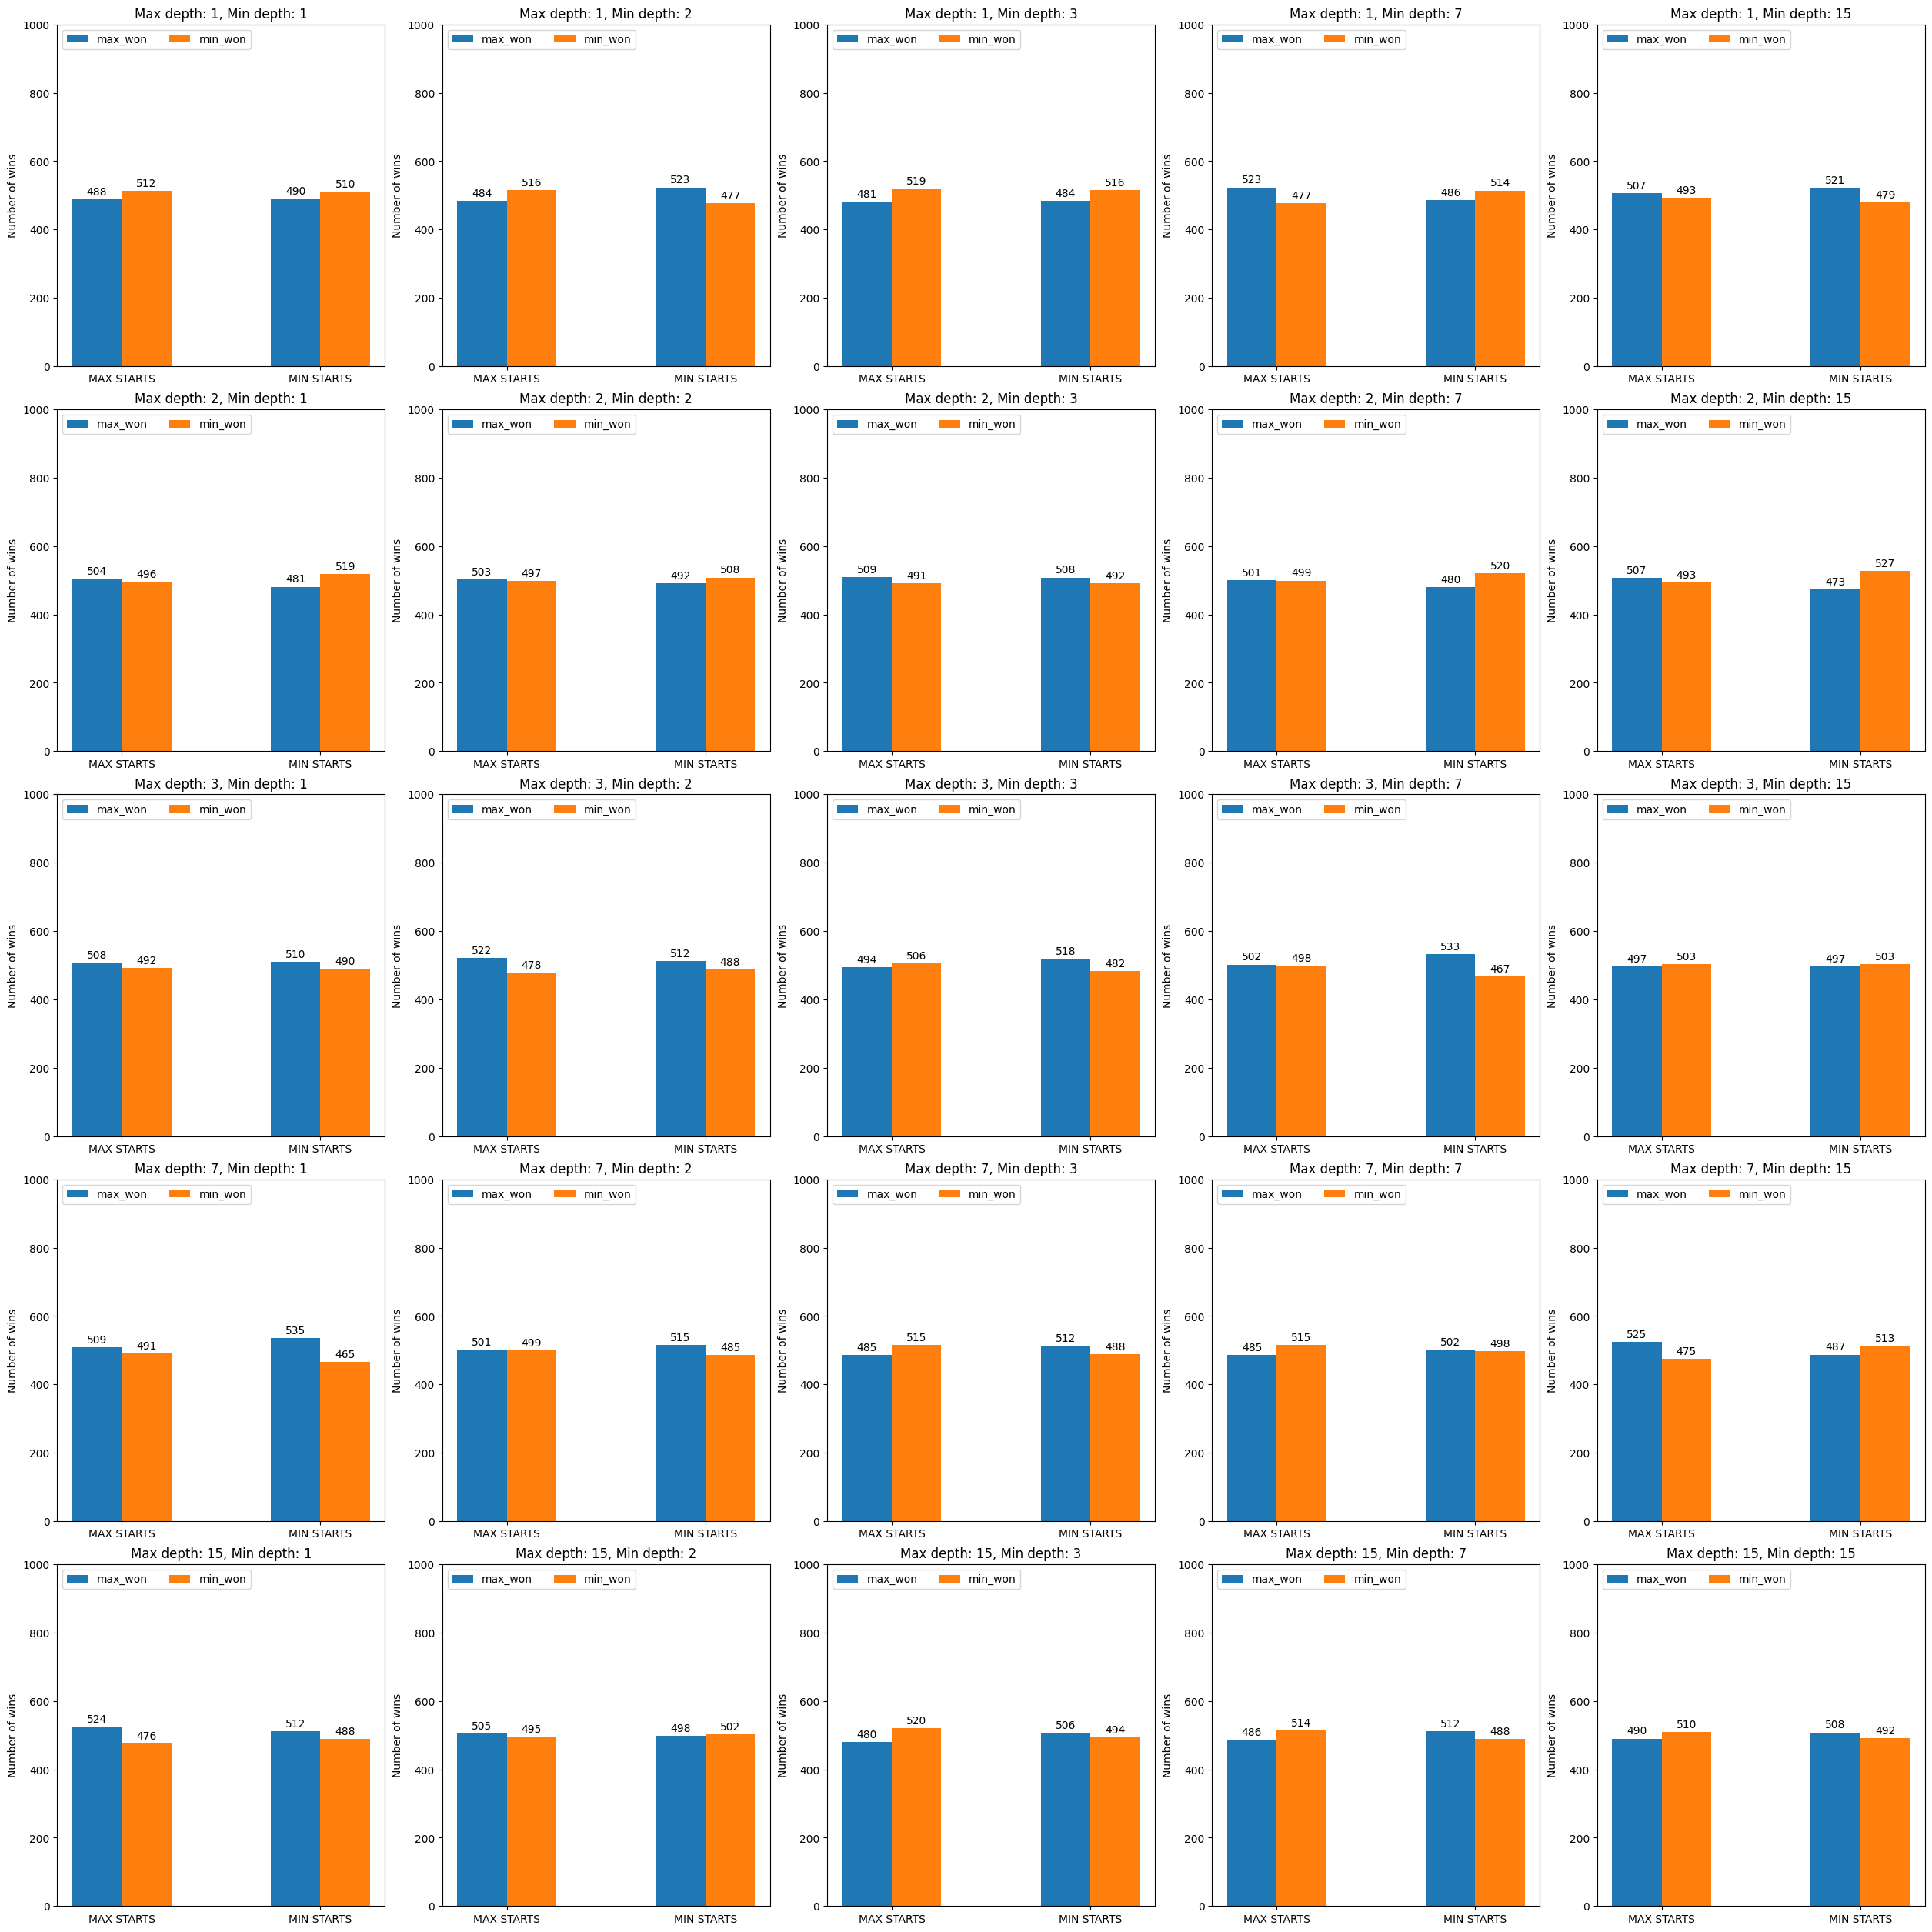

In [54]:
draw_graphs(random_heuristic, random_heuristic)

***Naive Heuristic vs Random Moves***

Upon comparing the naive heuristic with random move selection, a `significant advantage of using heuristics becomes apparent`. The Max player employing the heuristic `consistently won a higher percentage of games, ranging from 83% to 98%`, irrespective of whether they started the game. The difference in performance became more pronounced with increasing search depth for the player utilizing the heuristic. Greter the depth of heuristic, the better the performance.

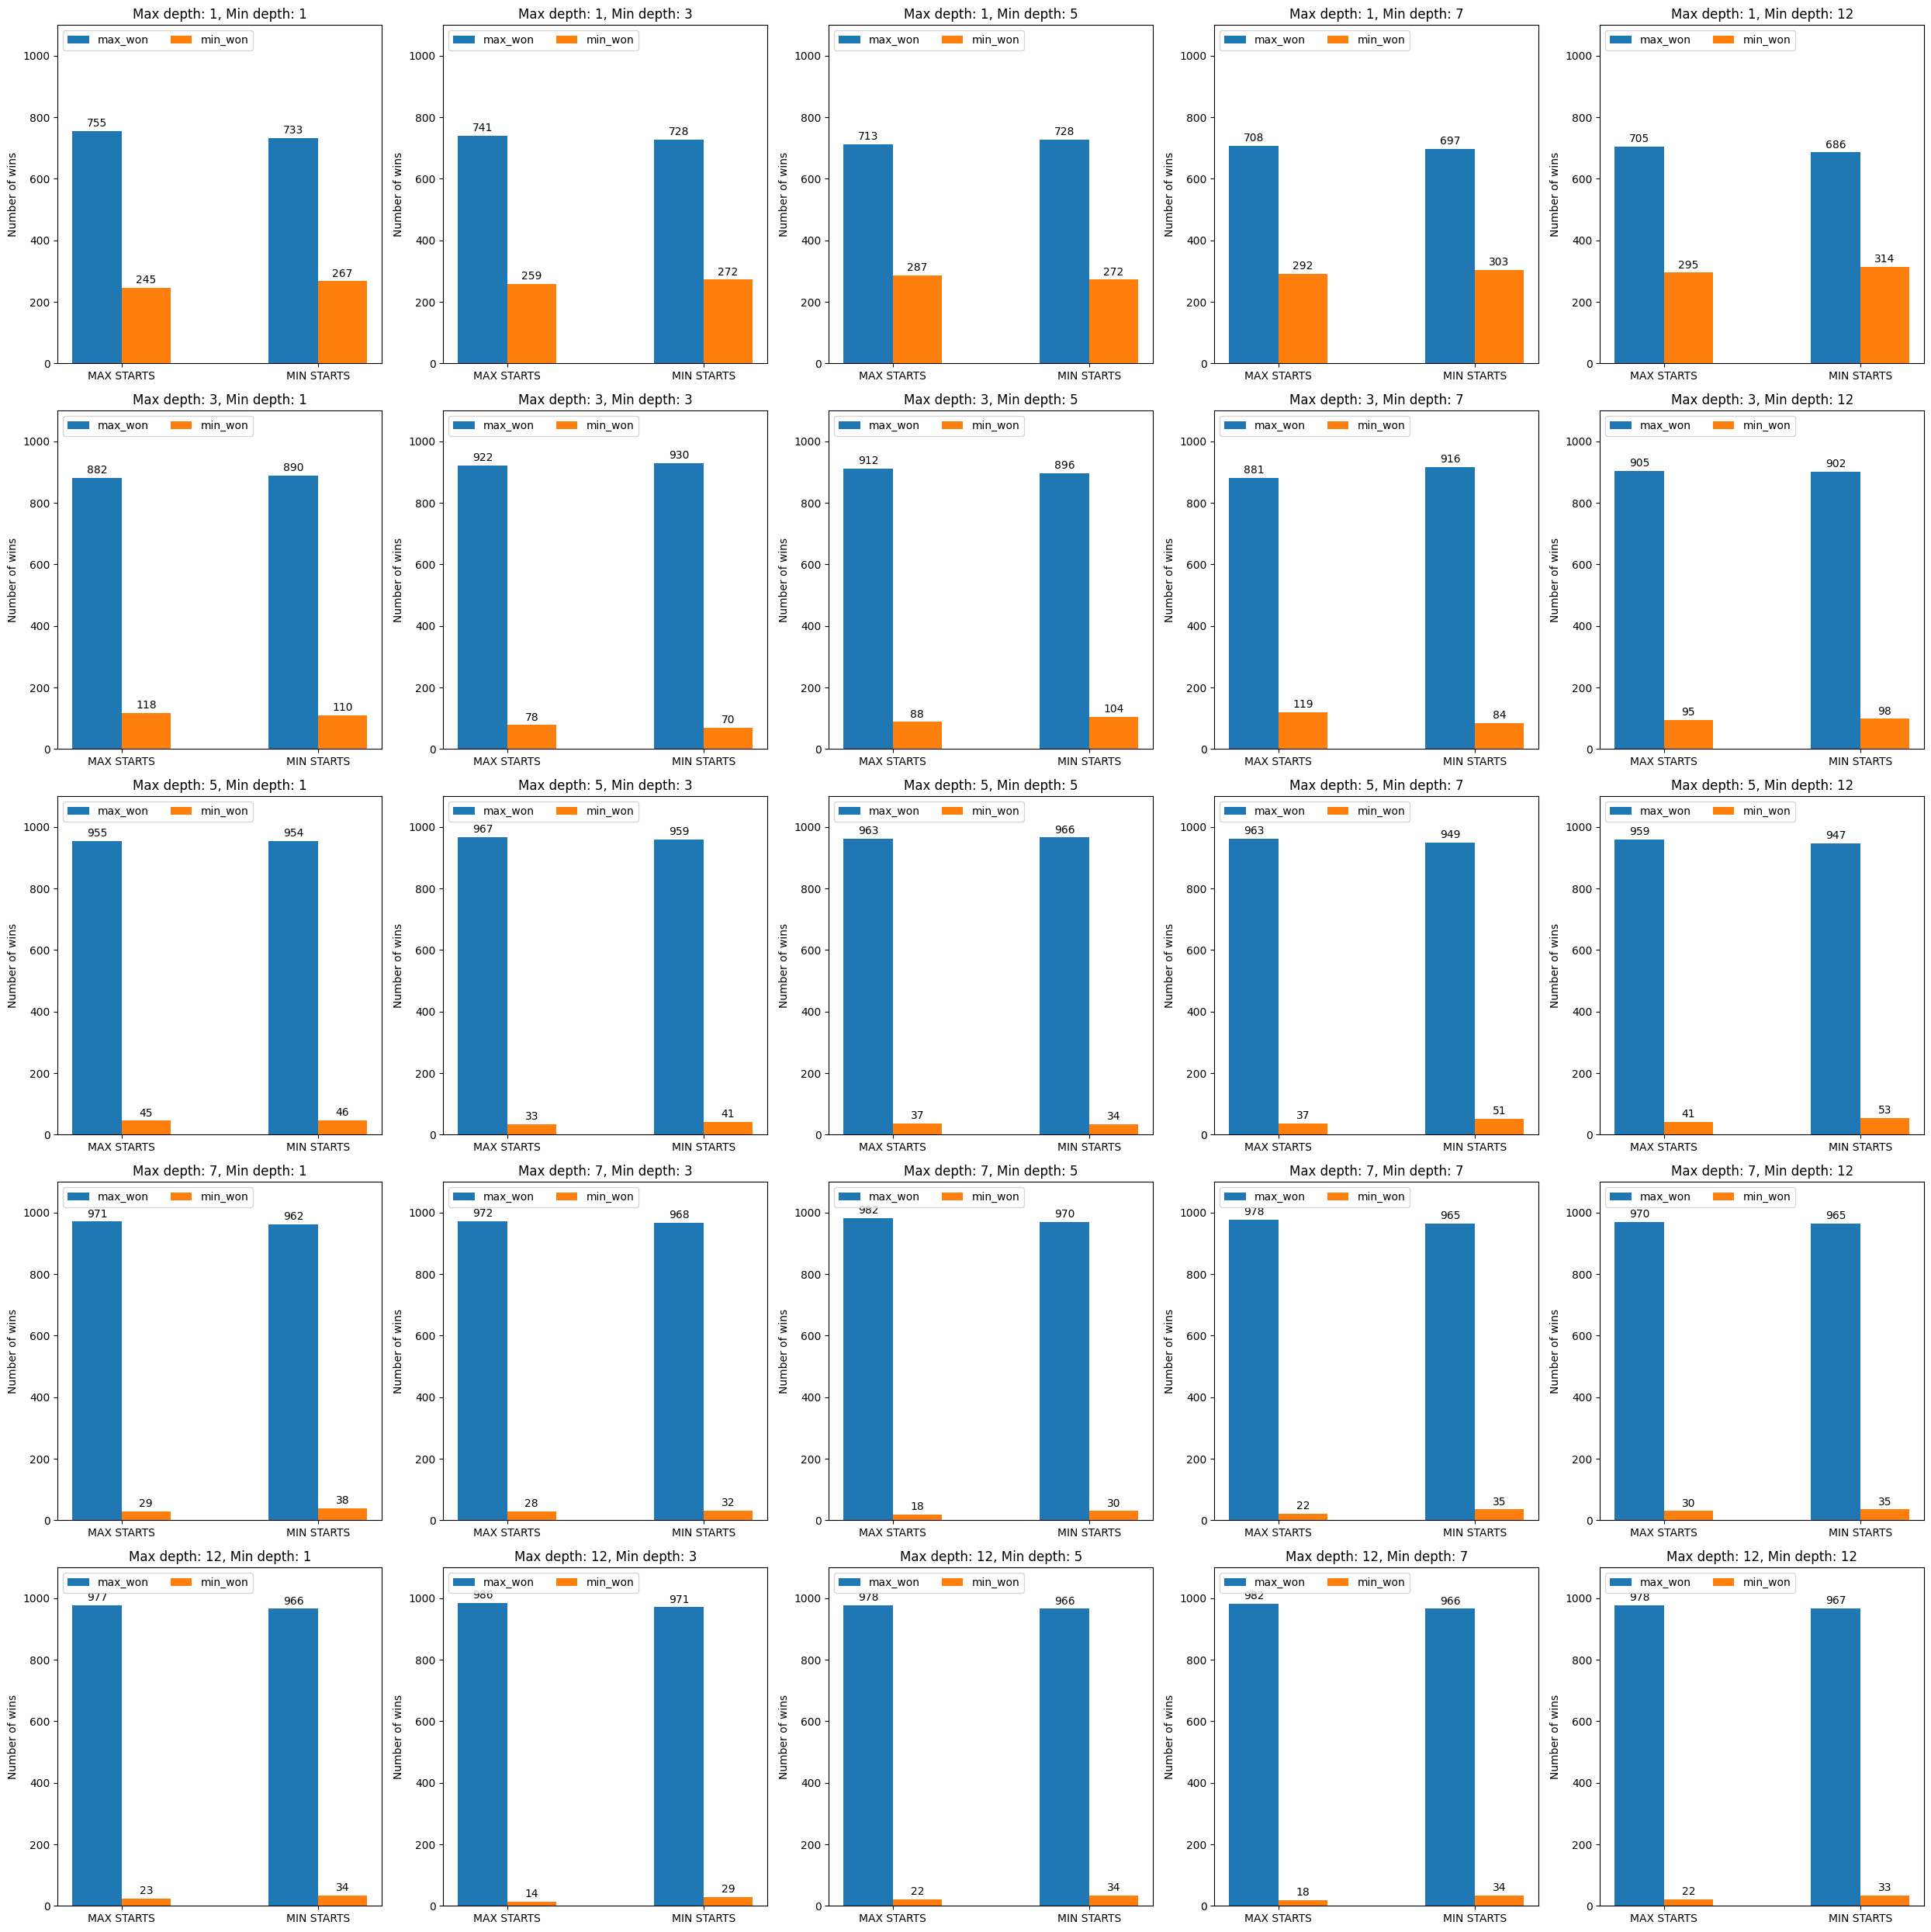

In [61]:
draw_graphs(naive_heuristic, random_heuristic)

***Comparison of My Heuristic and Naive Heuristic***

From the analysis of the charts of my_heuristic() and the naive_heuristic(), several conclusions can be drawn:

- For `small search depths (1-5)`, a significant `advantage of my_heuristic()` is evident `regardless of who starts`. It can be seen that within this range, my_heuristic() can win more games even with a smaller search depth compared to the naive heuristic.

- If the `difference in depths is large`, the heuristic with `greater depth definitely wins`.

- For `large depth values (7-12)`, the majority of games are `won by the player who starts the game`.

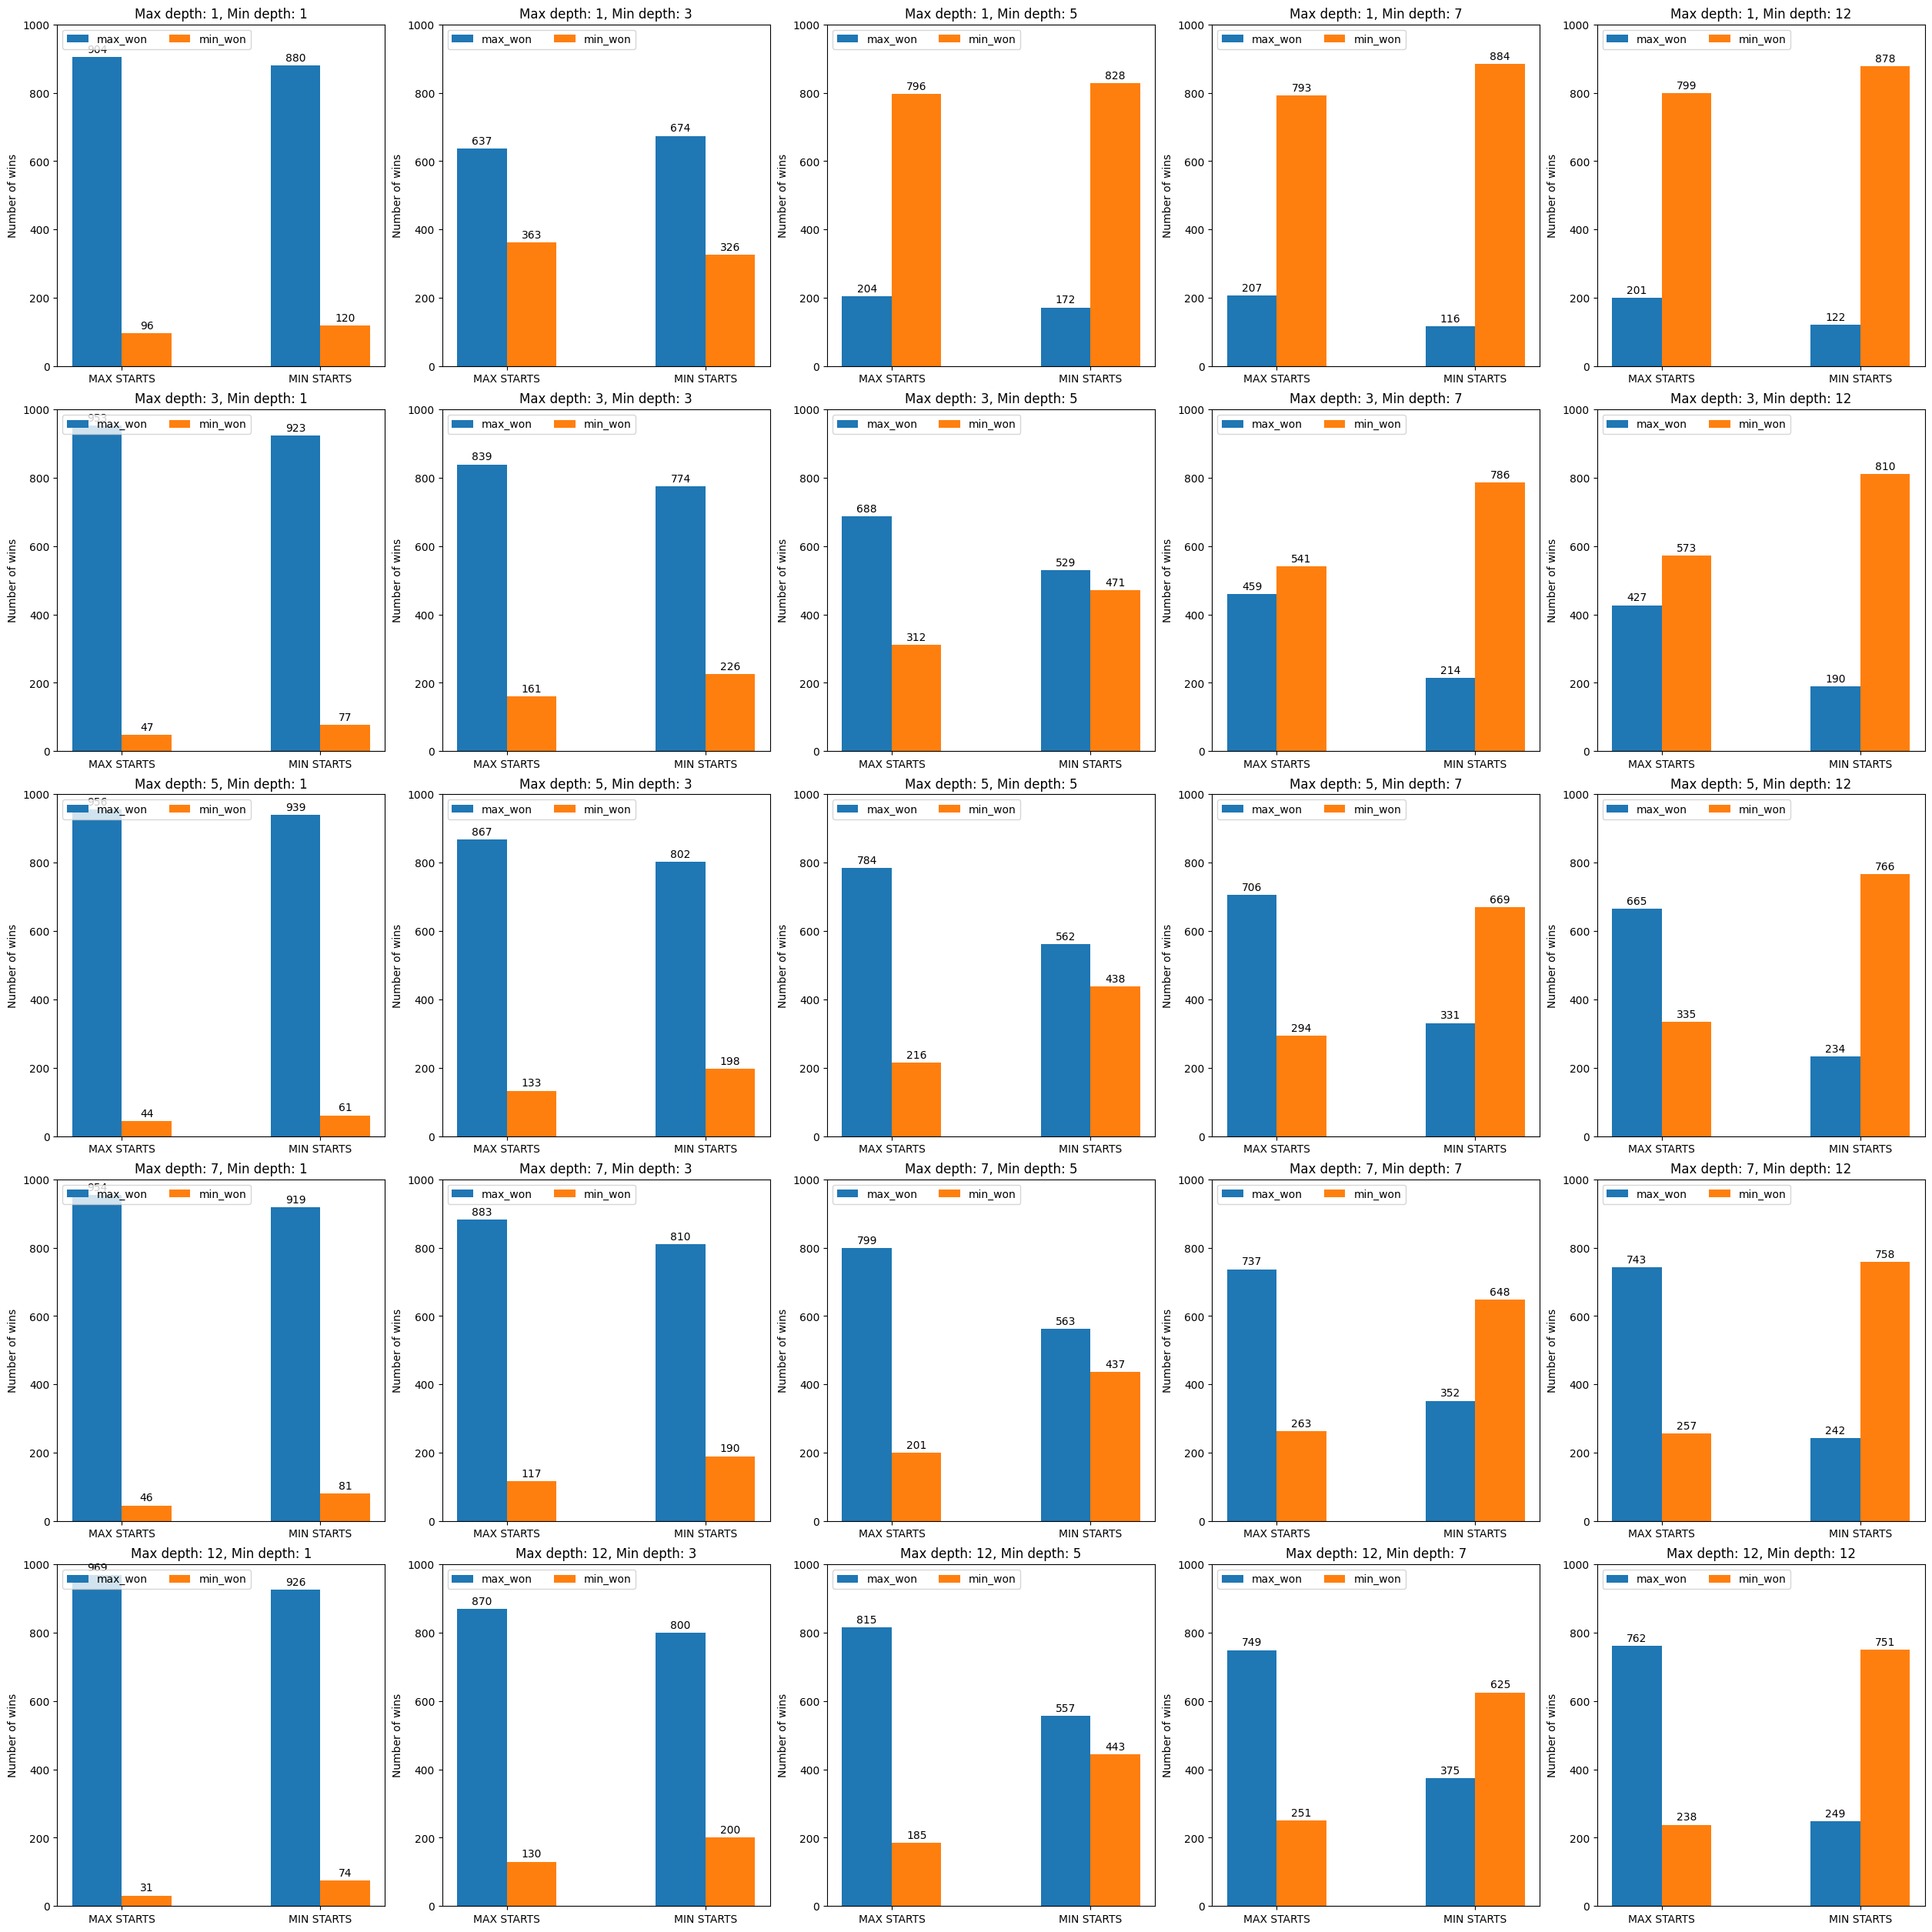

In [23]:
draw_graphs(my_heuristic, naive_heuristic)

The charts confirm my hypothesis regarding the heuristic. It turns out that if `N is specified`, the `player who starts the game wins in every case` if N is not a number that can be expressed as (K+1)X+1. On the other hand, if N is such a number, the first player will lose 100%. This is not dependent on the depth of search at all.

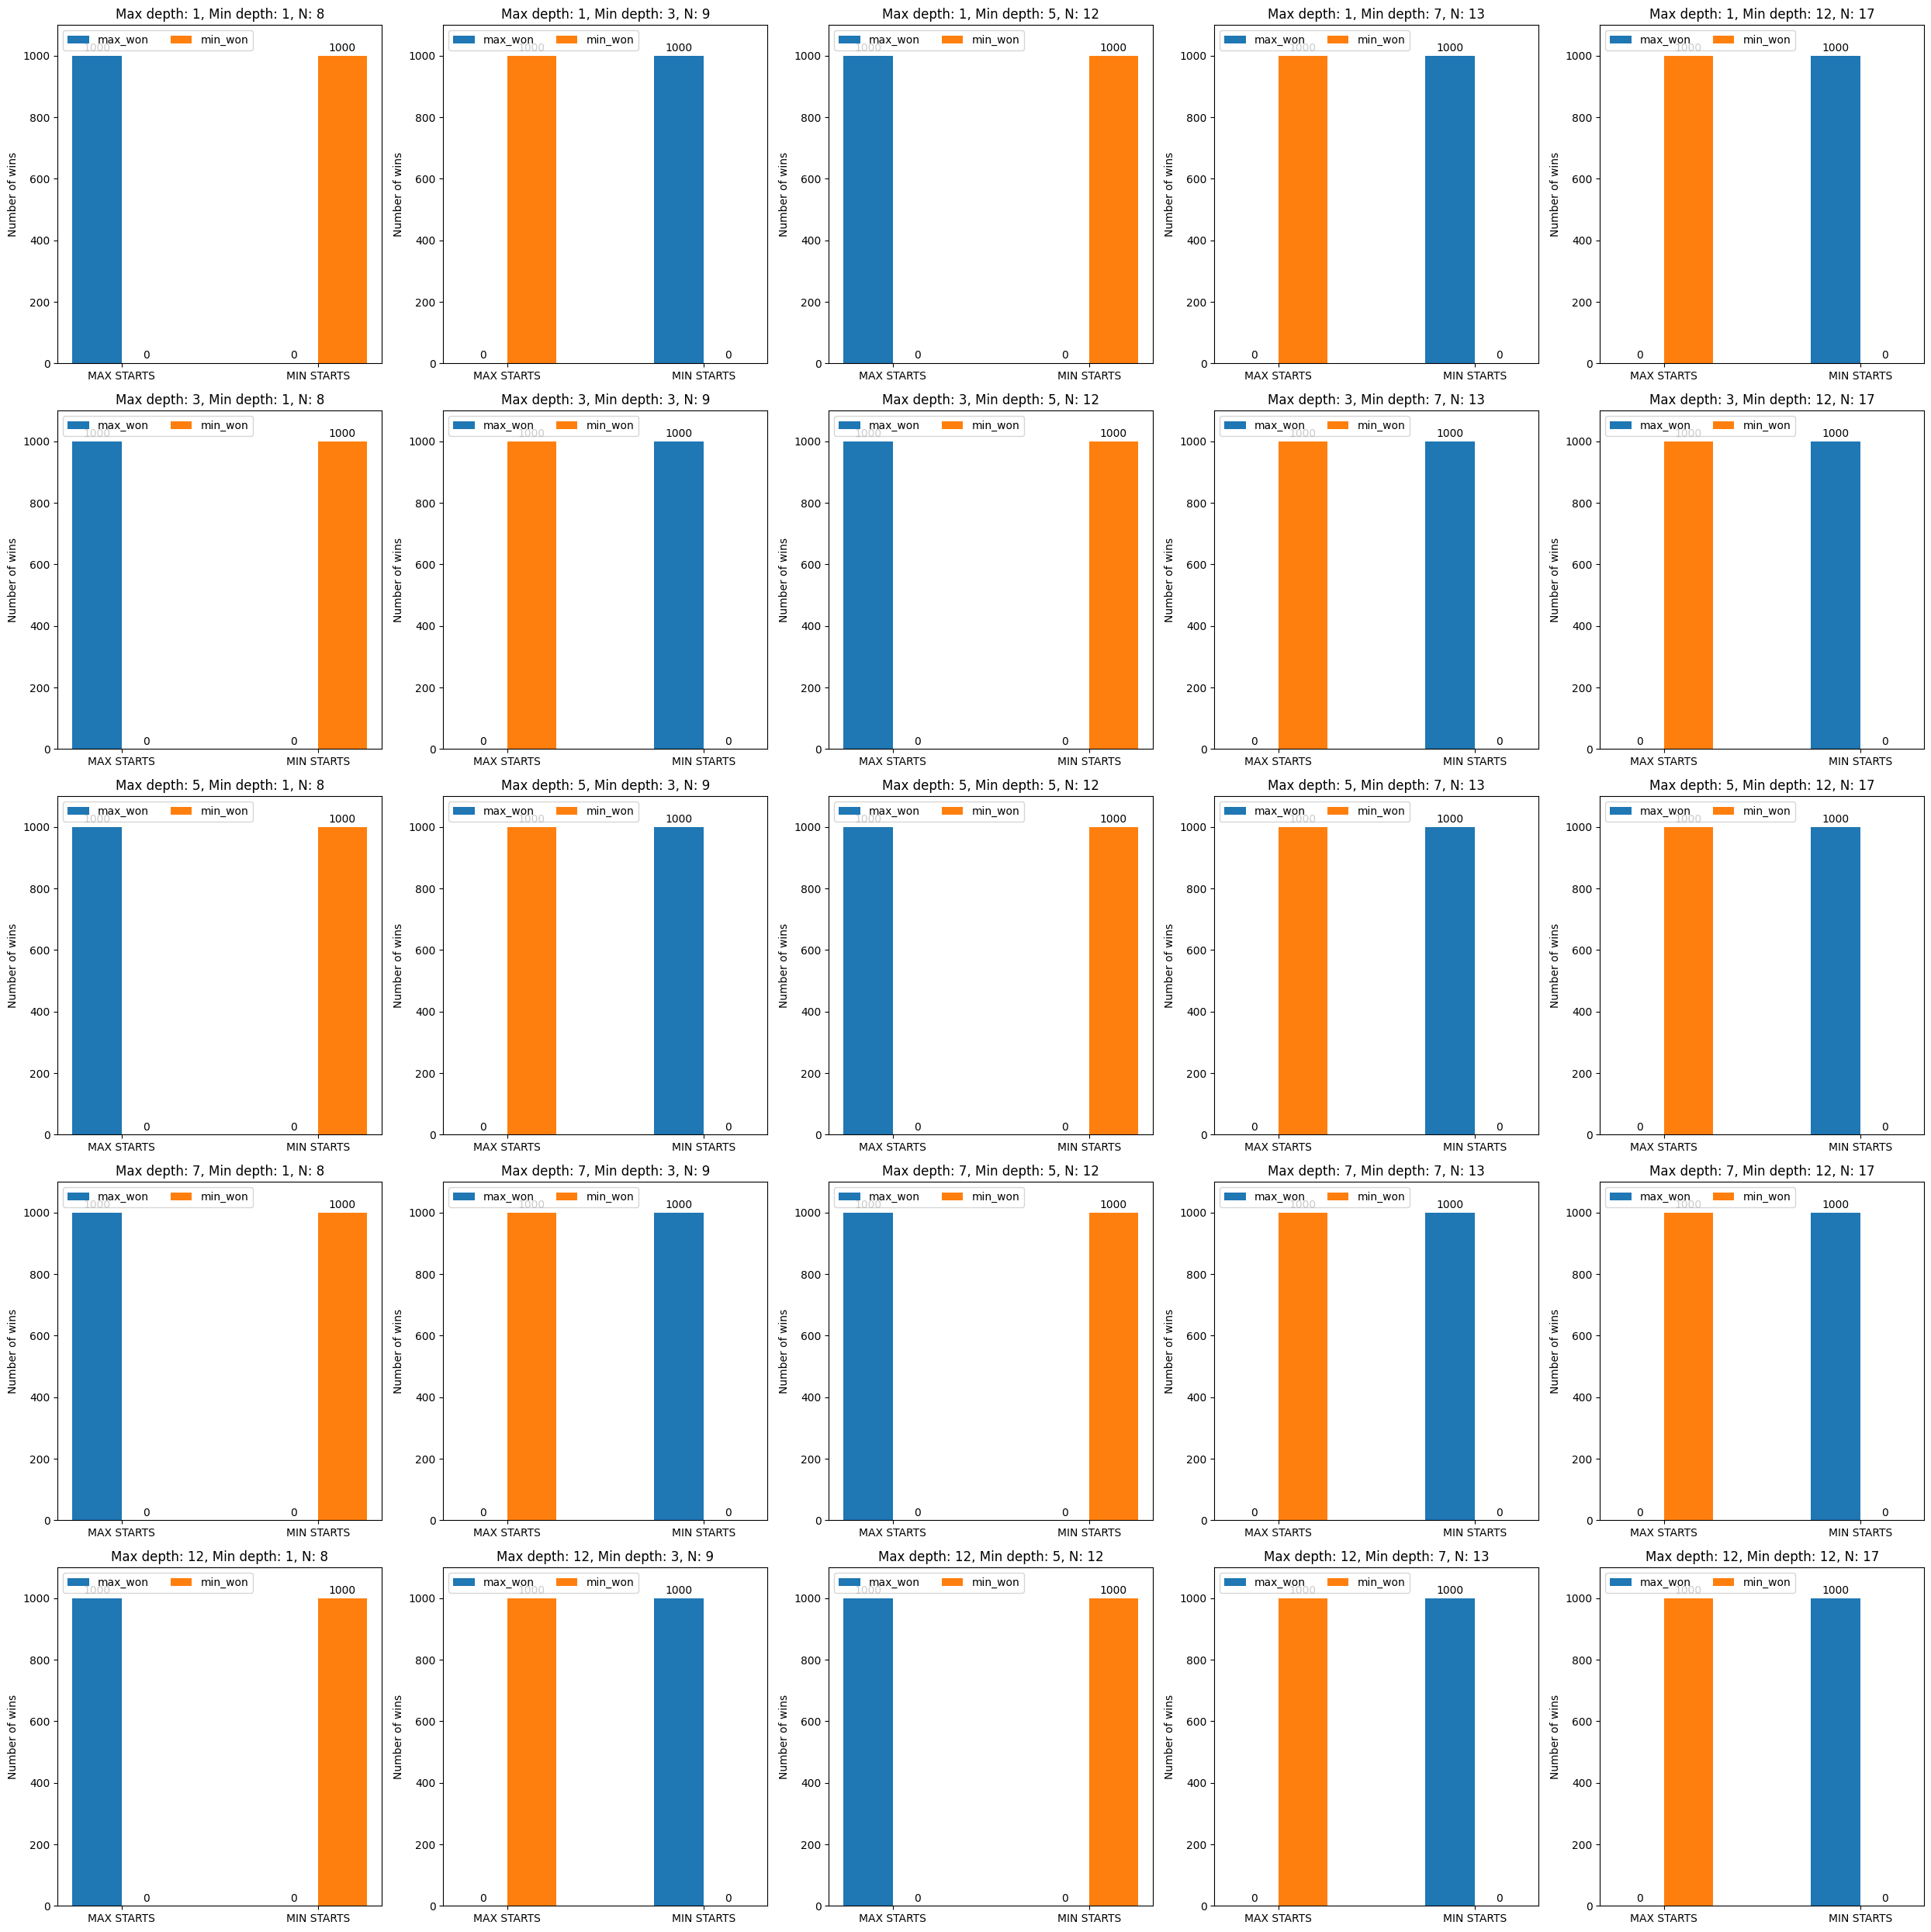

In [35]:
draw_graphs(broken_heuristic, broken_heuristic, True)

In [58]:
import ipytest
import pytest
ipytest.autoconfig()

In [60]:
def test_minimax_algorithm_max_starts():
    position = Position(4, 0, 0, None, 4)
    cost = minimax(position, 1, -math.inf, math.inf, True, naive_heuristic)
    assert cost == 1

def test_minimax_algorithm_min_starts():
    position = Position(4, 0, 0, None, 4)
    cost = minimax(position, 1, -math.inf, math.inf, False, naive_heuristic)
    assert cost == -1

def test_game_max_starts():
    game = Game(4, 0, 0, True, naive_heuristic, naive_heuristic, 3)
    assert game.play() == 'Max won!'

def test_game_min_starts():
    game = Game(4, 0, 0, False, naive_heuristic, naive_heuristic, 3)
    assert game.play() == 'Min won!'

ipytest.run()

....                                                                                         [100%]
4 passed in 0.01s


<ExitCode.OK: 0>